# 영화 리뷰 분류 : 이진 분류 예제
<br>

## 1. IMDB 데이터셋 로드하기
<br>
인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 5만 개로 이루어진 IMDB 데이터 셋<br>
훈련 데이터 2만 5000개, 테스트 데이터 2만 5000개로 이루어짐<br>
각각 50%는 부정, 50%는 긍정 리뷰로 구성되어 있음<br>
해당 데이터는 전처리되어 있어 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어 있음<br>
각각의 숫자는 고유한 단어를 나타냄

In [7]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

In [8]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [9]:
train_labels[0]

1

In [10]:
max([max(sequence) for sequence in train_data])

9999

### 원래 영어 단어로 바꿔보기

In [12]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i-3, '?') for i in train_data[0]])

In [17]:
reverse_word_index

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

## 2. 데이터 준비

### 리스트를 텐서로 바꾸는 두가지 방법
- 같은 길이가 되도록 리스트에 패딩(padding)을 추가하고 (samples, sequence_length) 크기의 정수 텐서로 변환<br>
  그 다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫번째 층으로 사용<br>
- 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변화<br>
  부동 소수 벡터 데이터를 다룰 수 있는 Dense층을 신경망의 첫 번째 층으로 사용<br>

### 정수 시퀀스를 이진 행렬로 인코딩

In [18]:
import numpy as np

def vectorize_sequence(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))   # 크기가 (len(sequences), dimension)이고 모든 원소가 0인 행렬 만들기
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.   # results[i]에서 특정 인덱스의 위치를 1로 만듬
    return results

x_train = vectorize_sequence(train_data)  # 훈련 데이터를 벡터로 변환
x_test = vectorize_sequence(test_data)    # 테스트 데이터를 벡터로 변환

In [19]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [20]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## 3. 신경망 모델 만들기

In [25]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## 4. 모델 컴파일 하기

In [26]:
model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

## 5. 훈련 검증
### 검증 세트 준비하기

In [27]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

### 모델 훈련하기

In [29]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = 20,
                   batch_size=512,
                    validation_data = (x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 13s 890us/step - loss: 0.3977 - acc: 0.8722 - val_loss: 0.3673 - val_acc: 0.8533
Epoch 2/20
15000/15000 [==============================] - 11s 728us/step - loss: 0.2684 - acc: 0.9153 - val_loss: 0.3091 - val_acc: 0.8803
Epoch 3/20
15000/15000 [==============================] - 6s 384us/step - loss: 0.2099 - acc: 0.9321 - val_loss: 0.2843 - val_acc: 0.8841
Epoch 4/20
15000/15000 [==============================] - 6s 391us/step - loss: 0.1641 - acc: 0.9492 - val_loss: 0.2753 - val_acc: 0.8875
Epoch 5/20
15000/15000 [==============================] - 6s 392us/step - loss: 0.1373 - acc: 0.9584 - val_loss: 0.3105 - val_acc: 0.8762
Epoch 6/20
15000/15000 [==============================] - 6s 390us/step - loss: 0.1096 - acc: 0.9679 - val_loss: 0.3133 - val_acc: 0.8815
Epoch 7/20
15000/15000 [==============================] - 6s 381us/step - loss: 0.0909 - acc: 0.9747 - val_loss: 0.3400 

### 훈련과 검증 손실 그리기

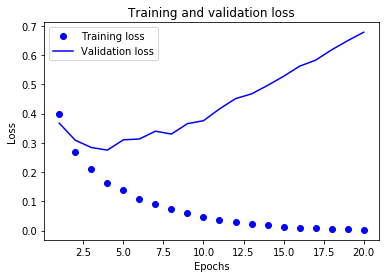

In [32]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 훈련과 검증 정확도 그리기

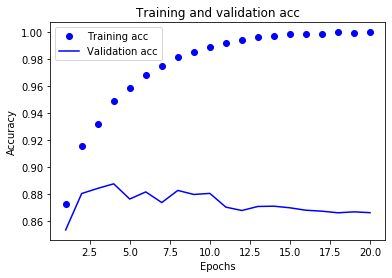

In [33]:
plt.clf() # 그래프 초기화
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

해당 모델이 overfitting됨을 알 수 있는 이유<br>
- epoch이 증가함에 따라 훈련 손실은 감소하고 훈련 정화도는 올라감<br>
- 그러나 validation 데이터의 경우 손실은 증가하고 정확도는 떨어지고 있음<br>
<br>
따라서 학습되면서 훈련데이터에 과대 적합되어 새로운 데이터(validation data)에 대해 유연하지 못함.<br>
즉, 일반화되지 못함<br>

## 6. 모델 평가하기

In [34]:
results = model.evaluate(x_test, y_test)

25000/25000 [==============================] - 18s 739us/step


In [35]:
results

[0.7456553946256638, 0.85272]

85.2%의 정확도를 가지는 모델임을 알 수 있음